In [1]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import simplstyles
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend

from compare_variance_residual.residual import residual_method
from compare_variance_residual.simulation import generate_dataset, save_scores
from compare_variance_residual.variance_partitioning import variance_partitioning

In [2]:
def get_path(alphas, cv, n_targets):
    path = os.path.join("results", f"targets={n_targets}", f"cv={cv}",
                        f"alphas={alphas.min()},{alphas.max()},{len(alphas)}", "varying training samples")
    os.makedirs(path, exist_ok=True)
    return path

# Save scores for varying training samples

In [4]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)
plt.style.use('nord-light-talk')

In [5]:
d_list = [100, 100, 100]
n_targets = 10000
n_samples_test = 100
scalars = [1 / 3, 1 / 3, 1 / 3]
noise_target = 0.1

cv = 10
alphas = np.logspace(-5, 5, 10)

In [6]:
import math

path = get_path(alphas, cv, n_targets)

numsteps = 10
samples_train = np.logspace(math.log(301, 10), math.log(30001, 10), numsteps).astype(int)
samples_train

array([  300,   501,   836,  1395,  2327,  3880,  6470, 10789, 17991,
       30000])

In [ ]:
save_scores(path, samples_train, d_list, scalars, n_targets, n_samples_test, noise_target, cv, alphas)

300
skipping, already exists
501
skipping, already exists
836
skipping, already exists
1395
skipping, already exists
2327
skipping, already exists
3880
skipping, already exists
6470
skipping, already exists
10789
skipping, already exists
17991
skipping, already exists
30000
data generated


# Load scores

In [29]:
vp = pd.DataFrame()
rm = pd.DataFrame()

for i, n_samples_train in enumerate(samples_train):
    scores = pd.read_csv(os.path.join(get_path(alphas, cv, n_targets), f"scores_{n_samples_train}.csv"))
    vp_x1_unique_predicted = scores['vp_x1_unique_score']
    vp_x1_se = (vp_x1_unique_predicted - scalars[1]).std()
    vp_scores = pd.DataFrame({
        'n_samples_train': n_samples_train,
        'vp_joint_score': scores['vp_joint_score'].mean(),
        'vp_x1_unique_score': vp_x1_unique_predicted.mean(),
        'vp_x1_se': vp_x1_se,
        'vp_x1_lower_se': vp_x1_unique_predicted.mean() - vp_x1_se,
        'vp_x1_upper_se': vp_x1_unique_predicted.mean() + vp_x1_se
    }, index=[i])

    rm_x1_unique_score = scores['rm_x1_unique_score']
    rm_x1_se = (rm_x1_unique_score - scalars[1]).std()
    rm_scores = pd.DataFrame({
        'n_samples_train': n_samples_train,
        'rm_x1_unique_score': rm_x1_unique_score.mean(),
        'rm_x1_se': rm_x1_se,
        'rm_x1_lower_se': rm_x1_unique_score.mean() - rm_x1_se,
        'rm_x1_upper_se': rm_x1_unique_score.mean() + rm_x1_se
    }, index=[i])

    vp = pd.concat([vp, vp_scores], ignore_index=True)
    rm = pd.concat([rm, rm_scores], ignore_index=True)
vp.head()
rm.head()

,n_samples_train,rm_x1_unique_score,rm_x1_se,rm_x1_lower_se,rm_x1_upper_se
0,300,-0.002965,0.075778,-0.078744,0.072813
1,501,0.026253,0.080667,-0.054414,0.106919
2,836,0.064320,0.120122,-0.055801,0.184442
3,1395,0.156406,0.109383,0.047023,0.265789
4,2327,0.217417,0.097996,0.119421,0.315413


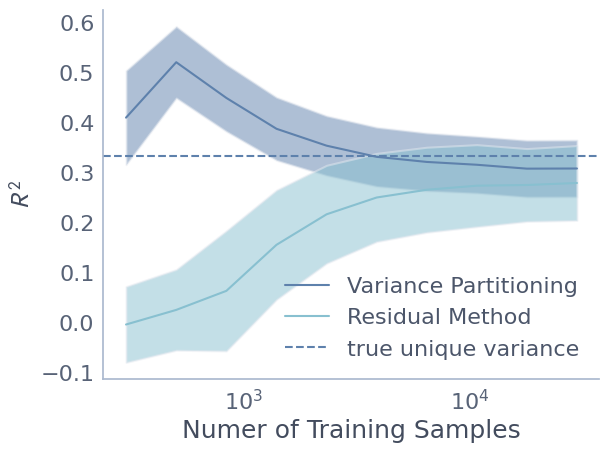

In [30]:
hue_order = ['Residual Method', 'Variance Partitioning', ]
sns.lineplot(data=vp, x='n_samples_train', y='vp_x1_unique_score', label='Variance Partitioning', palette='C2')
plt.fill_between(vp['n_samples_train'], vp['vp_x1_lower_se'], vp['vp_x1_upper_se'], alpha=0.5)
sns.lineplot(data=rm, x='n_samples_train', y='rm_x1_unique_score', label='Residual Method', hue_order=hue_order)
plt.fill_between(rm['n_samples_train'], rm['rm_x1_lower_se'], rm['rm_x1_upper_se'], alpha=0.5)
plt.axhline(scalars[1], linestyle='--', label='true unique variance')
plt.xlabel(r"Numer of Training Samples")
plt.ylabel(r"$R^2$")
plt.xscale('log', subs=[2, 3, 4, 5, 6, 7, 8, 9])
# update log locators

# set x formatter to log base 30 (30^0, 30^1, 30^2, ...)

plt.legend()